In [142]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from difflib import SequenceMatcher
import sys
import editdistance


from tqdm import tqdm

import torch
import torch.nn as nn

np.random.seed(0)

In [143]:
COLAB = True

In [144]:
DATASET_DIR = os.path.relpath("data")
MODELS_DIR = os.path.relpath("models")

In [145]:
if COLAB:
    from google.colab import drive
    # Mount on Google Drive
    drive.mount('/content/drive')
    ROOT_DIR = '/content/drive/MyDrive/speech_recognition'
    sys.path.append(ROOT_DIR)
    DATASET_DIR = os.path.join(ROOT_DIR, 'data')
    MODELS_DIR = os.path.join(ROOT_DIR, 'models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
# train_data = np.load("train_data.npz", allow_pickle=True)["data"]
# test_data = np.load("test_data.npz", allow_pickle=True)["data"]

In [147]:
with open(os.path.join(ROOT_DIR, "stateList.txt"), "r") as f:
    stateList = f.read().splitlines()

In [148]:
# Create a mapping from phonemes to indices
phoneme_list = sorted(set([s.split('_')[0] for s in stateList]))
phoneme_to_index = {ph: i for i, ph in enumerate(phoneme_list)}

# 5. Phoneme Recognition with Deep Neural Networks

In [149]:
from train_models import MLPRelu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_name, input_size, output_size):
    """
    Load the model from the given file.
    """
    n = int(model_name.split("_")[-1][0])
    model_path = os.path.join(MODELS_DIR, model_name+"_best_model.pt")
    model = MLPRelu(
        input_dim=input_size,
        output_dim=output_size,
        n_hidden=n)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model


def plot_run(model_name, ax, ymin, ymax):
    """
    Plot the loss and accuracy of the model during training.
    """
    run = np.load(os.path.join('models', model_name + "_run.npz"), allow_pickle=True)
    train_loss = run['train_losses']
    val_loss = run['val_losses']
    train_acc = run['train_accs']
    val_acc = run['val_accs']
    ax.plot(train_loss, label='Train Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ylim(ymin, ymax)
    ax.legend(loc='upper left')
    ax.set_title(f"Model: {model_name}")

    # Plot accuracy on the same graph but with a different y-axis
    ax2 = ax.twinx()
    ax2.plot(train_acc, label='Train Accuracy', linestyle='--')
    ax2.plot(val_acc, label='Validation Accuracy', linestyle='--')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')


def accuracy(model, X, y, batch_size=512):
    """
    Compute the accuracy of the model on the given data.
    """


def test_model(model_name, X_test, y_test):
    """
    Test the model on the test set and compute the accuracy and loss.
    """
    model = load_model(model_name, X_test.shape[1], y_test.shape[1])
    model.eval()

    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_test, y_test),
        batch_size=256,
        shuffle=False,
    )
    acc = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)
        acc += (predicted == labels).sum().item()
        loss += loss.item()
    return acc / len(X_test), loss


In [150]:
def collapse_repeated(sequence):
    """
    Collapse consecutive duplicates in a sequence.
    Example: [a, a, b, b, b, c] -> [a, b, c]
    """
    return [s for i, s in enumerate(sequence) if i == 0 or s != sequence[i - 1]]

def convert_state_to_phoneme(sequence):
    """
    Convert state-level labels (e.g., 'ox_1') to phoneme labels (e.g., 'ox').
    """
    return list(map(lambda s: s.split('_')[0], sequence))

def plot_confusion_matrix(y_pred, y_true, labels, title, normalize=True):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=False, fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()

    plt.savefig(os.path.join(ROOT_DIR, "figures", "_".join(title.lower().split(" ")) + ".png"))

In [151]:
def evaluate_predictions(model_name, predicted_states, target_states, stateList, phonemeIndex):
    """
    Evaluate predictions using:
    1. Frame-by-frame (state level)
    2. Frame-by-frame (phoneme level)
    3. Edit distance (state level)
    4. Edit distance (phoneme level)
    """
    # Convert indices to state labels
    idx2state = {i: state for i, state in enumerate(stateList)}
    pred_states = [idx2state[i] for i in predicted_states]
    true_states = [idx2state[i] for i in target_states]

    # 1. Frame-by-frame accuracy (state level)
    acc_state = np.mean(np.array(predicted_states) == np.array(target_states))
    plot_confusion_matrix(predicted_states, target_states, stateList, normalize='true', title=f"{model_name} State Confusion Matrix")

    # 2. Frame-by-frame accuracy (phoneme level)
    true_phonemes = [phonemeIndex[s.split('_')[0]] for s in true_states]
    pred_phonemes = [phonemeIndex[s.split('_')[0]] for s in pred_states]

    acc_phone = np.mean(np.array(pred_phonemes) == np.array(true_phonemes))

    # Create a mapping from phonemes to indices
    phoneme_list = sorted(set([s.split('_')[0] for s in stateList]))
    phoneme_to_index = {ph: i for i, ph in enumerate(phoneme_list)}
    plot_confusion_matrix(true_phonemes, pred_phonemes, labels=phoneme_list, normalize='true', title=f"{model_name} Phoneme Confusion Matrix")

    # 3. Edit distance (state level)
    pred_seq_collapse = collapse_repeated(pred_states)
    true_seq_collapse = collapse_repeated(true_states)
    edit_state = editdistance.eval(pred_seq_collapse, true_seq_collapse) / len(true_seq_collapse)

    # 4. Edit distance (phoneme level)
    pred_ph_seq = convert_state_to_phoneme(pred_seq_collapse)
    true_ph_seq = convert_state_to_phoneme(true_seq_collapse)
    edit_phone = editdistance.eval(pred_ph_seq, true_ph_seq) / len(true_ph_seq)

    print(f"Frame Accuracy (State):   {acc_state:.4f}")
    print(f"Frame Accuracy (Phoneme): {acc_phone:.4f}")
    print(f"Edit Distance (State):    {edit_state:.4f}")
    print(f"Edit Distance (Phoneme):  {edit_phone:.4f}")

    return acc_state, acc_phone, edit_state, edit_phone

In [152]:
def model_evaluation(stateList, phonemeIndex, features=["lmfcc", "mspec", "single_lmfcc", "single_mspec"], hidden_sizes=[1, 4], save_path=None):
    results = []

    for feature in tqdm(features):
        X_test = torch.load(os.path.join(DATASET_DIR, f"{feature}_test_x.pt"))
        y_test = torch.load(os.path.join(DATASET_DIR, "test_y.pt"))

        for n in tqdm(hidden_sizes):
            model_name = f"{feature}_{n}h"
            print(f"\nEvaluating {model_name}...")

            model = load_model(model_name, X_test.shape[1], y_test.shape[1])
            model.eval()

            # Inference
            with torch.no_grad():
                outputs = model(X_test.to(device))
                predicted = torch.argmax(outputs, dim=1).cpu().numpy()
                true = torch.argmax(y_test, dim=1).cpu().numpy()

            # Compute evaluation metrics
            acc_state, acc_phone, edit_state, edit_phone = evaluate_predictions(model_name, predicted, true, stateList, phonemeIndex)


            results.append({
                "model": model_name,
                "frame_acc_state": acc_state,
                "frame_acc_phone": acc_phone,
                "edit_dist_state": edit_state,
                "edit_dist_phone": edit_phone
            })

    if save_path:
        import pandas as pd
        df = pd.DataFrame(results)
        df.to_csv(save_path, index=False)
        print(f"\nSaved evaluation results to {save_path}")

    return results


  0%|          | 0/2 [00:00<?, ?it/s]


Evaluating lmfcc_1h...


  0%|          | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: 

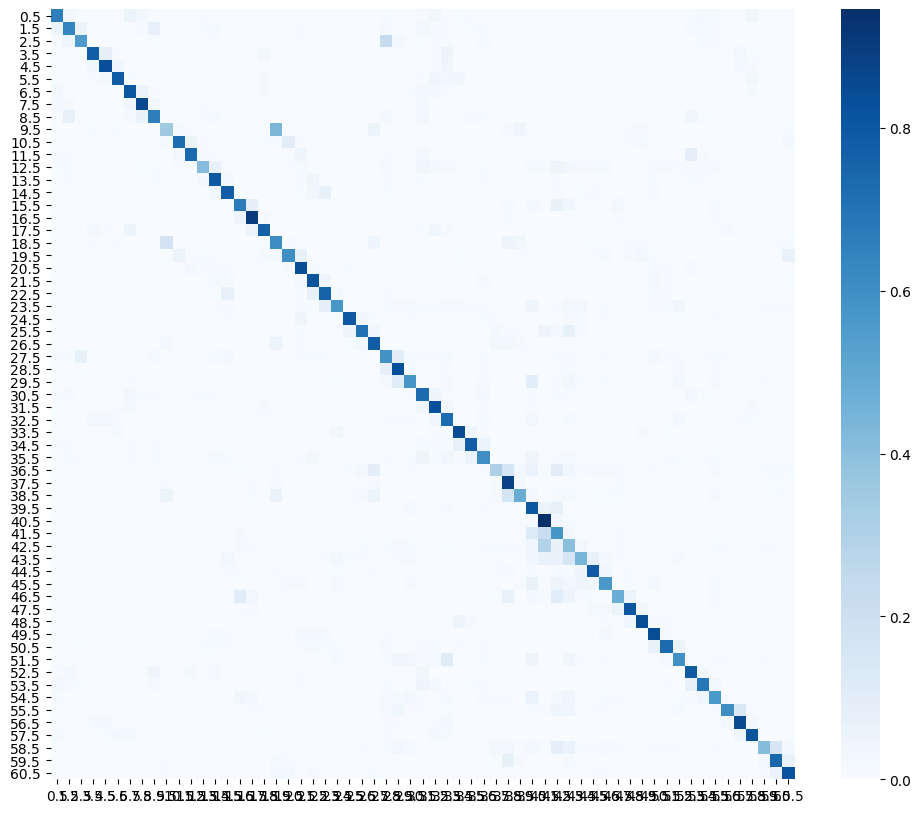

In [154]:
results = model_evaluation(stateList, phoneme_to_index, save_path = os.path.join(ROOT_DIR, "evaluation_metrics.csv"))

Evaluating lmfcc_1h...

Frame Accuracy (State):   0.7437

Frame Accuracy (Phoneme): 0.8312

Edit Distance (State):    0.5564

Edit Distance (Phoneme):  0.4959

In [141]:
for feature in ["lmfcc", "mspec", "single_lmfcc", "single_mspec"]:
    for n in [1, 4]:
        model_name = "{}_{}h".format(feature, n)
        print(f"Testing {model_name}...")
        X_test = torch.load(os.path.join(DATASET_DIR, f"{feature}_test_x.pt"))
        y_test = torch.load(os.path.join(DATASET_DIR, "test_y.pt"))
        acc, loss = test_model(model_name, X_test, y_test)
        print(f"Accuracy: {acc:.4f}, Loss: {loss:.4f}")
        print(f"Model: {model_name} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")
        print("-" * 50)


Testing lmfcc_1h...


KeyboardInterrupt: 

Testing lmfcc_1h...
Accuracy: 0.6785, Loss: 1.2957
Model: lmfcc_1h - Accuracy: 0.6785, Loss: 1.2957

Testing lmfcc_4h...
Accuracy: 0.6921, Loss: 1.6176
Model: lmfcc_4h - Accuracy: 0.6921, Loss: 1.6176

Testing mspec_1h...
Accuracy: 0.6721, Loss: 1.4181
Model: mspec_1h - Accuracy: 0.6721, Loss: 1.4181

Testing mspec_4h...
Accuracy: 0.6906, Loss: 2.3281
Model: mspec_4h - Accuracy: 0.6906, Loss: 2.3281

Testing single_lmfcc_1h...
Accuracy: 0.5277, Loss: 3.2187
Model: single_lmfcc_1h - Accuracy: 0.5277, Loss: 3.2187

Testing single_lmfcc_4h...
Accuracy: 0.5390, Loss: 2.7500
Model: single_lmfcc_4h - Accuracy: 0.5390, Loss: 2.7500

Testing single_mspec_1h...
Accuracy: 0.5458, Loss: 3.1510
Model: single_mspec_1h - Accuracy: 0.5458, Loss: 3.1510

Testing single_mspec_4h...
Accuracy: 0.5578, Loss: 2.5935
Model: single_mspec_4h - Accuracy: 0.5578, Loss: 2.5935

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, feature in enumerate(["single_lmfcc", "single_mspec"]):
    for j, n in enumerate([1, 4]):
        model_name = "{}_{}h".format(feature, n)
        ax = axes[i * 2 + j]
        plot_run(model_name, ax, 1.1, 1.9)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, feature in enumerate(["lmfcc", "mspec"]):
    for j, n in enumerate([1, 4]):
        model_name = "{}_{}h".format(feature, n)
        ax = axes[i * 2 + j]
        plot_run(model_name, ax, 0.5, 2)
plt.tight_layout()
plt.show()